<a href="https://colab.research.google.com/github/WarsameJ/Face-GANs/blob/main/Face_gans_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies

In [ ]:
! pip install Cython
! pip install torch
!pip install dset

In [ ]:
import io
import os 
import os.path
import glob
import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import torch
import torch.nn as nn
import torchvision
import dset
import shutil
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from typing import Any, Callable, cast, Dict, List, Optional, Tuple
from typing import Union

os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir /content/FOLDER_DIR
!mkdir /content/FOLDER_DIR/DATA_DIR

#Get Data

In [ ]:
!kaggle datasets download -d arnaud58/flickrfaceshq-dataset-ffhq -p /content/FOLDER_DIR/DATA_DIR

100% 19.5G/19.5G [03:41<00:00, 101MB/s]
100% 19.5G/19.5G [03:41<00:00, 94.3MB/s]


In [ ]:
!unzip -u "/content/FOLDER_DIR/DATA_DIR/flickrfaceshq-dataset-ffhq.zip" -d "/content/FOLDER_DIR/DATA_DIR"

Streaming output truncated to the last 5000 lines.
  inflating: /content/FOLDER_DIR/DATA_DIR/49001.png  
  inflating: /content/FOLDER_DIR/DATA_DIR/49002.png  
  inflating: /content/FOLDER_DIR/DATA_DIR/49003.png  
  inflating: /content/FOLDER_DIR/DATA_DIR/49004.png  
  inflating: /content/FOLDER_DIR/DATA_DIR/49005.png  
  inflating: /content/FOLDER_DIR/DATA_DIR/49006.png  
  inflating: /content/FOLDER_DIR/DATA_DIR/49007.png  
  inflating: /content/FOLDER_DIR/DATA_DIR/49008.png  
  inflating: /content/FOLDER_DIR/DATA_DIR/49009.png  
  inflating: /content/FOLDER_DIR/DATA_DIR/49010.png  
  inflating: /content/FOLDER_DIR/DATA_DIR/49011.png  
  inflating: /content/FOLDER_DIR/DATA_DIR/49012.png  
  inflating: /content/FOLDER_DIR/DATA_DIR/49013.png  
  inflating: /content/FOLDER_DIR/DATA_DIR/49014.png  
  inflating: /content/FOLDER_DIR/DATA_DIR/49015.png  
  inflating: /content/FOLDER_DIR/DATA_DIR/49016.png  
  inflating: /content/FOLDER_DIR/DATA_DIR/49017.png  
  inflating: /content/FOLDER_DI

In [ ]:
FOLDER_DIR = "/content/FOLDER_DIR"
DATA_DIR = "/content/FOLDER_DIR/DATA_DIR"

# Preprocess Images

In [ ]:
image_size = 64
stats = (0.5, 0.5, 0.5),(0.5, 0.5, 0.5)

In [ ]:
dataset = ImageFolder( root = FOLDER_DIR, transform = T.Compose([
                    T.Resize(image_size),
                    T.CenterCrop(image_size),
                    T.ToTensor(),
                    T.Normalize(*stats)]))

In [ ]:
batch_size = 128

In [ ]:
train_dl = DataLoader(dataset, batch_size, shuffle = True, pin_memory = True, num_workers = 3)


In [ ]:
def denorm(image_tensors):
    
    return image_tensors * stats[0][1] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    

In [ ]:
def show_batch(dl, nmax=64):
    for images,_ in dl:
        show_images(images)
        break
#shows the 8 by 8 break out of images from data

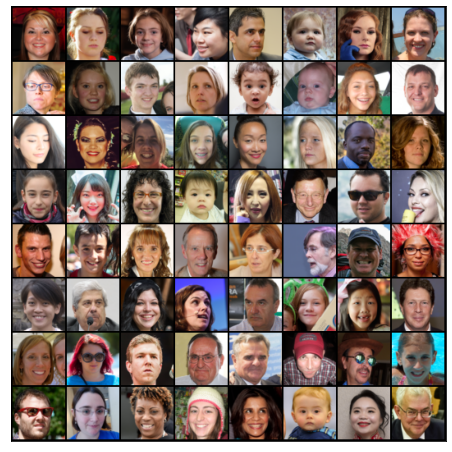

In [ ]:
show_batch(train_dl)


In [ ]:
def get_default_device():
    
    if torch.cuda.is_available:
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
def to_device(data, device):
    
    if isinstance(data, (list, tuple)):
        return [to_device(each, device) for each in data]
    else:
        return data.to(device, non_blocking = True)

In [ ]:
class DeviceDataLoader():
    
    def __init__(self, dl, device):
        
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        
        return len(self.dl)    

In [ ]:
device = get_default_device()

train_dl = DeviceDataLoader(train_dl, device)

#Build Discriminator


In [ ]:
discriminator = nn.Sequential(

    #initial dim : 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace = True),
    
    #dim : 64 x 32 x 32
    nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace = True),
    
    #dim : 128 x 16 x 16
    nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace = True),
    
    #dim : 256 x 8 x 8
    nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace = True),
    
    #dim : 512 x 4 x 4
    nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),
    
    #dim : 1 x 1 x 1
    nn.Flatten(),
    nn.Sigmoid()
    
)

In [ ]:
discriminator = to_device(discriminator, device)


In [ ]:
latent_size = 128


#Build Generator

In [ ]:
generator = nn.Sequential(

    #initial dim : latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    
    #dim : 512 x 4 x 4
    nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    #dim : 256 x 8 x 8
    nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    
    #dim : 128 x 16 x 16
    nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    
    #dim : 64 x 32 x 32
    nn.ConvTranspose2d(64, 3, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.Tanh()
)

torch.Size([128, 3, 64, 64])


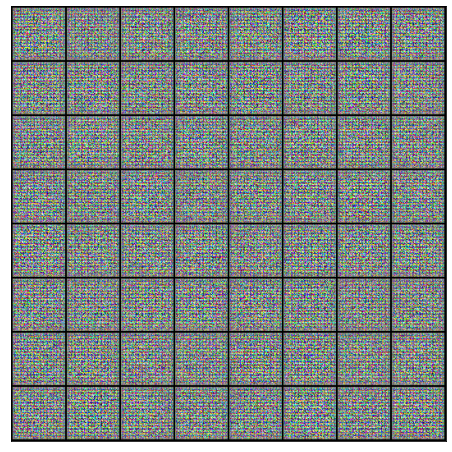

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)

print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)


#Train Discriminator and Generator


In [ ]:
import torch.nn.functional as F


In [ ]:
def train_discriminator(real_images, opt_d):
    
    opt_d.zero_grad()
    
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device = device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
    fake_images = generator(latent)
    
    fake_preds = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1, device = device)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    
    return loss.item(), real_score, fake_score


In [ ]:
def train_generator(opt_g):
    
    opt_g.zero_grad()
    
    
    latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
    fake_images = generator(latent)
    
    fake_preds = discriminator(fake_images)
    targets = torch.ones(fake_images.size(0), 1, device = device)
    loss = F.binary_cross_entropy(fake_preds, targets)
    
    loss.backward()
    opt_g.step()
    
    return loss.item()


In [ ]:
from torchvision.utils import save_image


In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)


In [ ]:
def save_samples(index, latent_tensors, show = True):
    
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))


In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


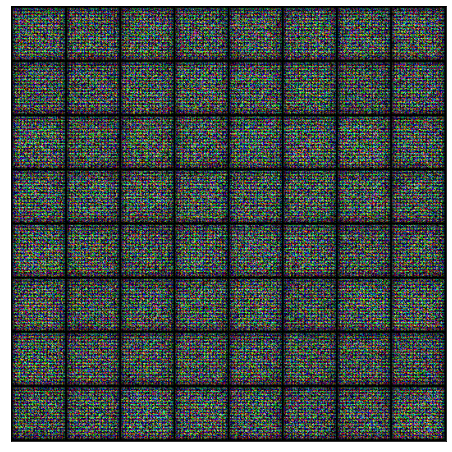

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm


# Run GAN

In [ ]:
def fit(epochs, lr, start_idx = 1):
    
    torch.cuda.empty_cache()
    
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    opt_d = torch.optim.Adam(discriminator.parameters(), lr = lr, betas = (0.5, 0.999)) 
    opt_g = torch.optim.Adam(generator.parameters(), lr = lr, betas = (0.5, 0.999)) 
    
    for epoch in range(epochs):
        
        for real_images,_ in tqdm(train_dl):
            
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            
            loss_g = train_generator(opt_g)
            
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        save_samples(epoch+start_idx, fixed_latent, show=False)
        
    return losses_g, losses_d, real_scores, fake_scores


In [ ]:
lr = 0.0002
epochs = 300 #12 gan hours


In [37]:
history = fit(epochs, lr)

  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [1/300], loss_g: 6.9817, loss_d: 0.0083, real_score: 0.9939, fake_score: 0.0021
Saving generated-images-0001.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [2/300], loss_g: 4.4744, loss_d: 0.3476, real_score: 0.8905, fake_score: 0.1551
Saving generated-images-0002.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [3/300], loss_g: 4.7375, loss_d: 0.2715, real_score: 0.8915, fake_score: 0.0891
Saving generated-images-0003.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [4/300], loss_g: 2.1699, loss_d: 0.3096, real_score: 0.9283, fake_score: 0.1724
Saving generated-images-0004.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [5/300], loss_g: 6.3997, loss_d: 0.4525, real_score: 0.9615, fake_score: 0.2986
Saving generated-images-0005.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [6/300], loss_g: 0.5410, loss_d: 3.2067, real_score: 0.0893, fake_score: 0.0007
Saving generated-images-0006.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [7/300], loss_g: 2.4122, loss_d: 0.4131, real_score: 0.7717, fake_score: 0.0965
Saving generated-images-0007.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [8/300], loss_g: 6.2781, loss_d: 0.7003, real_score: 0.9794, fake_score: 0.4372
Saving generated-images-0008.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [9/300], loss_g: 8.0375, loss_d: 5.9453, real_score: 0.9998, fake_score: 0.9927
Saving generated-images-0009.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [10/300], loss_g: 3.3944, loss_d: 0.2350, real_score: 0.8774, fake_score: 0.0807
Saving generated-images-0010.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [11/300], loss_g: 1.3444, loss_d: 0.6050, real_score: 0.6198, fake_score: 0.0565
Saving generated-images-0011.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [12/300], loss_g: 2.9886, loss_d: 0.8545, real_score: 0.7330, fake_score: 0.3109
Saving generated-images-0012.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [13/300], loss_g: 2.4680, loss_d: 0.2758, real_score: 0.8096, fake_score: 0.0257
Saving generated-images-0013.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [14/300], loss_g: 3.5801, loss_d: 0.1421, real_score: 0.9340, fake_score: 0.0652
Saving generated-images-0014.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [15/300], loss_g: 3.0562, loss_d: 0.2099, real_score: 0.8895, fake_score: 0.0757
Saving generated-images-0015.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [16/300], loss_g: 0.1940, loss_d: 1.6200, real_score: 0.3015, fake_score: 0.0018
Saving generated-images-0016.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [17/300], loss_g: 1.8654, loss_d: 0.3722, real_score: 0.7957, fake_score: 0.0838
Saving generated-images-0017.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [18/300], loss_g: 2.3422, loss_d: 0.1515, real_score: 0.9049, fake_score: 0.0443
Saving generated-images-0018.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [19/300], loss_g: 2.2203, loss_d: 0.1925, real_score: 0.8857, fake_score: 0.0590
Saving generated-images-0019.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [20/300], loss_g: 3.1564, loss_d: 0.1429, real_score: 0.9445, fake_score: 0.0765
Saving generated-images-0020.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [21/300], loss_g: 4.3333, loss_d: 0.1739, real_score: 0.9565, fake_score: 0.1137
Saving generated-images-0021.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [22/300], loss_g: 5.8338, loss_d: 0.4805, real_score: 0.9730, fake_score: 0.3093
Saving generated-images-0022.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [23/300], loss_g: 6.5997, loss_d: 0.3683, real_score: 0.9797, fake_score: 0.2632
Saving generated-images-0023.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [24/300], loss_g: 3.8410, loss_d: 0.2015, real_score: 0.9735, fake_score: 0.1464
Saving generated-images-0024.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [25/300], loss_g: 3.7403, loss_d: 0.1785, real_score: 0.9031, fake_score: 0.0612
Saving generated-images-0025.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [26/300], loss_g: 1.6445, loss_d: 0.3486, real_score: 0.7627, fake_score: 0.0361
Saving generated-images-0026.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [27/300], loss_g: 5.1755, loss_d: 0.2624, real_score: 0.9826, fake_score: 0.1950
Saving generated-images-0027.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [28/300], loss_g: 3.5100, loss_d: 0.1762, real_score: 0.8878, fake_score: 0.0429
Saving generated-images-0028.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [29/300], loss_g: 1.0232, loss_d: 0.5285, real_score: 0.7312, fake_score: 0.1186
Saving generated-images-0029.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [30/300], loss_g: 4.9608, loss_d: 0.0614, real_score: 0.9621, fake_score: 0.0216
Saving generated-images-0030.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [31/300], loss_g: 0.1164, loss_d: 4.4605, real_score: 0.0501, fake_score: 0.0013
Saving generated-images-0031.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [32/300], loss_g: 4.6090, loss_d: 0.0909, real_score: 0.9804, fake_score: 0.0631
Saving generated-images-0032.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [33/300], loss_g: 3.6772, loss_d: 0.1032, real_score: 0.9491, fake_score: 0.0443
Saving generated-images-0033.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [34/300], loss_g: 0.5872, loss_d: 0.4266, real_score: 0.7138, fake_score: 0.0394
Saving generated-images-0034.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [35/300], loss_g: 6.0627, loss_d: 0.0498, real_score: 0.9695, fake_score: 0.0177
Saving generated-images-0035.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [36/300], loss_g: 3.3404, loss_d: 0.1243, real_score: 0.9328, fake_score: 0.0484
Saving generated-images-0036.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [37/300], loss_g: 3.1583, loss_d: 0.4938, real_score: 0.8205, fake_score: 0.2004
Saving generated-images-0037.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [38/300], loss_g: 2.2211, loss_d: 0.8953, real_score: 0.6638, fake_score: 0.2791
Saving generated-images-0038.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [39/300], loss_g: 4.2285, loss_d: 0.1481, real_score: 0.9656, fake_score: 0.0986
Saving generated-images-0039.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [40/300], loss_g: 4.3028, loss_d: 0.0935, real_score: 0.9746, fake_score: 0.0623
Saving generated-images-0040.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [41/300], loss_g: 3.3100, loss_d: 0.1366, real_score: 0.9025, fake_score: 0.0232
Saving generated-images-0041.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [42/300], loss_g: 4.8899, loss_d: 0.0607, real_score: 0.9845, fake_score: 0.0422
Saving generated-images-0042.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [43/300], loss_g: 4.3747, loss_d: 0.0425, real_score: 0.9930, fake_score: 0.0337
Saving generated-images-0043.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [44/300], loss_g: 6.5482, loss_d: 0.1233, real_score: 0.9889, fake_score: 0.0877
Saving generated-images-0044.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [45/300], loss_g: 1.2408, loss_d: 2.2015, real_score: 0.2346, fake_score: 0.0116
Saving generated-images-0045.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [46/300], loss_g: 2.3917, loss_d: 0.4398, real_score: 0.7255, fake_score: 0.0365
Saving generated-images-0046.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [47/300], loss_g: 3.4346, loss_d: 0.0950, real_score: 0.9460, fake_score: 0.0314
Saving generated-images-0047.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [48/300], loss_g: 7.3986, loss_d: 0.3601, real_score: 0.9962, fake_score: 0.2524
Saving generated-images-0048.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [49/300], loss_g: 0.8178, loss_d: 0.3012, real_score: 0.7939, fake_score: 0.0219
Saving generated-images-0049.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [50/300], loss_g: 2.7542, loss_d: 0.5880, real_score: 0.8645, fake_score: 0.2936
Saving generated-images-0050.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [51/300], loss_g: 5.7064, loss_d: 0.0270, real_score: 0.9908, fake_score: 0.0172
Saving generated-images-0051.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [52/300], loss_g: 3.2354, loss_d: 0.1562, real_score: 0.9050, fake_score: 0.0384
Saving generated-images-0052.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [53/300], loss_g: 6.9784, loss_d: 0.3858, real_score: 0.9955, fake_score: 0.2737
Saving generated-images-0053.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [54/300], loss_g: 5.3866, loss_d: 0.0510, real_score: 0.9918, fake_score: 0.0394
Saving generated-images-0054.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [55/300], loss_g: 2.6527, loss_d: 0.1808, real_score: 0.8735, fake_score: 0.0305
Saving generated-images-0055.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [56/300], loss_g: 4.2167, loss_d: 0.0701, real_score: 0.9678, fake_score: 0.0336
Saving generated-images-0056.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [57/300], loss_g: 4.5063, loss_d: 0.1217, real_score: 0.9872, fake_score: 0.0948
Saving generated-images-0057.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [58/300], loss_g: 5.1249, loss_d: 0.3004, real_score: 0.9867, fake_score: 0.2037
Saving generated-images-0058.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [59/300], loss_g: 2.9606, loss_d: 0.1005, real_score: 0.9320, fake_score: 0.0256
Saving generated-images-0059.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [60/300], loss_g: 5.2933, loss_d: 0.0500, real_score: 0.9616, fake_score: 0.0094
Saving generated-images-0060.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [61/300], loss_g: 4.2579, loss_d: 0.0776, real_score: 0.9397, fake_score: 0.0118
Saving generated-images-0061.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [62/300], loss_g: 2.4044, loss_d: 0.1629, real_score: 0.8932, fake_score: 0.0260
Saving generated-images-0062.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [63/300], loss_g: 4.3821, loss_d: 0.0876, real_score: 0.9654, fake_score: 0.0444
Saving generated-images-0063.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [64/300], loss_g: 5.4033, loss_d: 0.0444, real_score: 0.9773, fake_score: 0.0202
Saving generated-images-0064.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [65/300], loss_g: 5.2790, loss_d: 0.0352, real_score: 0.9872, fake_score: 0.0212
Saving generated-images-0065.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [66/300], loss_g: 2.7983, loss_d: 0.1346, real_score: 0.8979, fake_score: 0.0099
Saving generated-images-0066.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [67/300], loss_g: 5.3061, loss_d: 0.0507, real_score: 0.9730, fake_score: 0.0199
Saving generated-images-0067.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [68/300], loss_g: 2.7519, loss_d: 0.5473, real_score: 0.7999, fake_score: 0.1686
Saving generated-images-0068.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [69/300], loss_g: 1.2333, loss_d: 0.2765, real_score: 0.7859, fake_score: 0.0123
Saving generated-images-0069.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [70/300], loss_g: 6.9084, loss_d: 0.0142, real_score: 0.9902, fake_score: 0.0042
Saving generated-images-0070.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [71/300], loss_g: 4.2779, loss_d: 0.0774, real_score: 0.9558, fake_score: 0.0276
Saving generated-images-0071.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [72/300], loss_g: 5.3368, loss_d: 0.0315, real_score: 0.9976, fake_score: 0.0277
Saving generated-images-0072.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [73/300], loss_g: 1.6759, loss_d: 1.6292, real_score: 0.3600, fake_score: 0.0210
Saving generated-images-0073.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [74/300], loss_g: 1.7773, loss_d: 0.3828, real_score: 0.7667, fake_score: 0.0370
Saving generated-images-0074.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [75/300], loss_g: 6.5328, loss_d: 0.0955, real_score: 0.9179, fake_score: 0.0029
Saving generated-images-0075.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [76/300], loss_g: 4.2697, loss_d: 0.2392, real_score: 0.9026, fake_score: 0.1035
Saving generated-images-0076.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [77/300], loss_g: 6.6776, loss_d: 0.0296, real_score: 0.9857, fake_score: 0.0145
Saving generated-images-0077.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [78/300], loss_g: 4.0665, loss_d: 0.1051, real_score: 0.9208, fake_score: 0.0150
Saving generated-images-0078.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [79/300], loss_g: 2.9981, loss_d: 0.1498, real_score: 0.9124, fake_score: 0.0487
Saving generated-images-0079.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [80/300], loss_g: 5.6679, loss_d: 0.0773, real_score: 0.9934, fake_score: 0.0633
Saving generated-images-0080.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [81/300], loss_g: 5.1020, loss_d: 0.0635, real_score: 0.9615, fake_score: 0.0226
Saving generated-images-0081.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [82/300], loss_g: 5.0150, loss_d: 0.0388, real_score: 0.9892, fake_score: 0.0262
Saving generated-images-0082.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [83/300], loss_g: 0.7533, loss_d: 0.2310, real_score: 0.8185, fake_score: 0.0146
Saving generated-images-0083.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [84/300], loss_g: 4.5962, loss_d: 0.0500, real_score: 0.9641, fake_score: 0.0093
Saving generated-images-0084.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [85/300], loss_g: 6.0598, loss_d: 0.0199, real_score: 0.9855, fake_score: 0.0052
Saving generated-images-0085.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [86/300], loss_g: 4.7164, loss_d: 0.0614, real_score: 0.9582, fake_score: 0.0130
Saving generated-images-0086.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [87/300], loss_g: 6.1063, loss_d: 0.0562, real_score: 0.9984, fake_score: 0.0478
Saving generated-images-0087.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [88/300], loss_g: 4.6719, loss_d: 0.0717, real_score: 0.9629, fake_score: 0.0244
Saving generated-images-0088.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [89/300], loss_g: 5.0013, loss_d: 0.0217, real_score: 0.9836, fake_score: 0.0050
Saving generated-images-0089.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [90/300], loss_g: 6.9090, loss_d: 0.0326, real_score: 0.9974, fake_score: 0.0266
Saving generated-images-0090.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [91/300], loss_g: 5.8754, loss_d: 0.0504, real_score: 0.9923, fake_score: 0.0386
Saving generated-images-0091.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [92/300], loss_g: 6.3684, loss_d: 0.0362, real_score: 0.9882, fake_score: 0.0224
Saving generated-images-0092.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [93/300], loss_g: 6.7361, loss_d: 0.1066, real_score: 0.9900, fake_score: 0.0808
Saving generated-images-0093.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [94/300], loss_g: 3.9244, loss_d: 0.1118, real_score: 0.9109, fake_score: 0.0049
Saving generated-images-0094.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [95/300], loss_g: 4.9668, loss_d: 0.0812, real_score: 0.9435, fake_score: 0.0187
Saving generated-images-0095.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [96/300], loss_g: 5.2669, loss_d: 0.1691, real_score: 0.9440, fake_score: 0.0656
Saving generated-images-0096.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [97/300], loss_g: 5.5626, loss_d: 0.1029, real_score: 0.9390, fake_score: 0.0319
Saving generated-images-0097.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [98/300], loss_g: 6.1911, loss_d: 0.0385, real_score: 0.9882, fake_score: 0.0246
Saving generated-images-0098.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [99/300], loss_g: 5.9511, loss_d: 0.0081, real_score: 0.9993, fake_score: 0.0072
Saving generated-images-0099.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [100/300], loss_g: 5.8350, loss_d: 0.0389, real_score: 0.9794, fake_score: 0.0165
Saving generated-images-0100.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [101/300], loss_g: 5.0896, loss_d: 0.0273, real_score: 0.9775, fake_score: 0.0043
Saving generated-images-0101.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [102/300], loss_g: 5.2797, loss_d: 0.0311, real_score: 0.9969, fake_score: 0.0232
Saving generated-images-0102.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [103/300], loss_g: 5.0290, loss_d: 0.0906, real_score: 0.9322, fake_score: 0.0101
Saving generated-images-0103.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [104/300], loss_g: 7.0253, loss_d: 0.0104, real_score: 0.9966, fake_score: 0.0068
Saving generated-images-0104.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [105/300], loss_g: 4.2647, loss_d: 0.0324, real_score: 0.9900, fake_score: 0.0212
Saving generated-images-0105.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [106/300], loss_g: 3.9618, loss_d: 0.0913, real_score: 0.9309, fake_score: 0.0107
Saving generated-images-0106.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [107/300], loss_g: 4.9224, loss_d: 0.0716, real_score: 0.9648, fake_score: 0.0324
Saving generated-images-0107.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [108/300], loss_g: 5.9140, loss_d: 0.0363, real_score: 0.9849, fake_score: 0.0196
Saving generated-images-0108.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [109/300], loss_g: 5.5842, loss_d: 0.0326, real_score: 0.9909, fake_score: 0.0216
Saving generated-images-0109.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [110/300], loss_g: 6.2897, loss_d: 0.0211, real_score: 0.9877, fake_score: 0.0082
Saving generated-images-0110.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [111/300], loss_g: 6.8159, loss_d: 0.0385, real_score: 0.9974, fake_score: 0.0325
Saving generated-images-0111.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [112/300], loss_g: 5.8370, loss_d: 0.7751, real_score: 0.9301, fake_score: 0.3684
Saving generated-images-0112.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [113/300], loss_g: 5.0231, loss_d: 0.0997, real_score: 0.9914, fake_score: 0.0746
Saving generated-images-0113.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [114/300], loss_g: 5.9652, loss_d: 0.0495, real_score: 0.9624, fake_score: 0.0094
Saving generated-images-0114.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [115/300], loss_g: 2.3643, loss_d: 0.1501, real_score: 0.8920, fake_score: 0.0165
Saving generated-images-0115.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [116/300], loss_g: 5.6085, loss_d: 0.0494, real_score: 0.9596, fake_score: 0.0066
Saving generated-images-0116.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [117/300], loss_g: 0.2115, loss_d: 0.3323, real_score: 0.7743, fake_score: 0.0336
Saving generated-images-0117.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [118/300], loss_g: 5.6516, loss_d: 0.0557, real_score: 0.9954, fake_score: 0.0465
Saving generated-images-0118.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [119/300], loss_g: 9.1642, loss_d: 0.0878, real_score: 0.9293, fake_score: 0.0004
Saving generated-images-0119.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [120/300], loss_g: 7.6670, loss_d: 0.0260, real_score: 0.9933, fake_score: 0.0169
Saving generated-images-0120.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [121/300], loss_g: 4.2251, loss_d: 0.2252, real_score: 0.9263, fake_score: 0.0935
Saving generated-images-0121.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [122/300], loss_g: 5.0235, loss_d: 0.0194, real_score: 0.9899, fake_score: 0.0088
Saving generated-images-0122.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [123/300], loss_g: 4.6429, loss_d: 0.0418, real_score: 0.9812, fake_score: 0.0185
Saving generated-images-0123.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [124/300], loss_g: 5.8505, loss_d: 0.0323, real_score: 0.9981, fake_score: 0.0251
Saving generated-images-0124.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [125/300], loss_g: 7.3253, loss_d: 0.0111, real_score: 0.9965, fake_score: 0.0070
Saving generated-images-0125.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [126/300], loss_g: 7.2628, loss_d: 0.0291, real_score: 0.9740, fake_score: 0.0018
Saving generated-images-0126.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [127/300], loss_g: 4.9295, loss_d: 0.0543, real_score: 0.9657, fake_score: 0.0176
Saving generated-images-0127.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [128/300], loss_g: 5.4416, loss_d: 0.0105, real_score: 0.9982, fake_score: 0.0085
Saving generated-images-0128.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [129/300], loss_g: 5.3669, loss_d: 0.1180, real_score: 0.9184, fake_score: 0.0131
Saving generated-images-0129.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [130/300], loss_g: 6.3599, loss_d: 0.0403, real_score: 0.9841, fake_score: 0.0226
Saving generated-images-0130.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [131/300], loss_g: 6.4348, loss_d: 0.0319, real_score: 0.9895, fake_score: 0.0200
Saving generated-images-0131.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [132/300], loss_g: 5.0972, loss_d: 0.0701, real_score: 0.9475, fake_score: 0.0098
Saving generated-images-0132.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [133/300], loss_g: 1.0160, loss_d: 0.1651, real_score: 0.8601, fake_score: 0.0017
Saving generated-images-0133.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [134/300], loss_g: 7.3522, loss_d: 0.0046, real_score: 0.9989, fake_score: 0.0034
Saving generated-images-0134.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [135/300], loss_g: 6.7968, loss_d: 0.0059, real_score: 0.9988, fake_score: 0.0046
Saving generated-images-0135.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [136/300], loss_g: 3.5948, loss_d: 0.1289, real_score: 0.9485, fake_score: 0.0556
Saving generated-images-0136.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [137/300], loss_g: 4.5236, loss_d: 0.0701, real_score: 0.9467, fake_score: 0.0124
Saving generated-images-0137.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [138/300], loss_g: 6.2674, loss_d: 0.0307, real_score: 0.9744, fake_score: 0.0041
Saving generated-images-0138.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [139/300], loss_g: 5.8553, loss_d: 0.0931, real_score: 0.9716, fake_score: 0.0548
Saving generated-images-0139.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [140/300], loss_g: 5.1521, loss_d: 0.0772, real_score: 0.9977, fake_score: 0.0600
Saving generated-images-0140.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [141/300], loss_g: 4.6290, loss_d: 0.0190, real_score: 0.9997, fake_score: 0.0177
Saving generated-images-0141.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [142/300], loss_g: 4.2082, loss_d: 0.2739, real_score: 0.8756, fake_score: 0.0619
Saving generated-images-0142.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [143/300], loss_g: 9.2931, loss_d: 0.0536, real_score: 0.9685, fake_score: 0.0095
Saving generated-images-0143.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [144/300], loss_g: 6.0947, loss_d: 0.0159, real_score: 0.9990, fake_score: 0.0140
Saving generated-images-0144.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [145/300], loss_g: 7.4953, loss_d: 0.0205, real_score: 0.9861, fake_score: 0.0060
Saving generated-images-0145.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [146/300], loss_g: 7.1024, loss_d: 0.0183, real_score: 0.9885, fake_score: 0.0060
Saving generated-images-0146.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [147/300], loss_g: 6.7195, loss_d: 0.0444, real_score: 0.9706, fake_score: 0.0094
Saving generated-images-0147.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [148/300], loss_g: 8.1689, loss_d: 0.0538, real_score: 0.9701, fake_score: 0.0186
Saving generated-images-0148.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [149/300], loss_g: 6.5172, loss_d: 0.0169, real_score: 0.9995, fake_score: 0.0149
Saving generated-images-0149.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [150/300], loss_g: 6.6396, loss_d: 0.0138, real_score: 0.9997, fake_score: 0.0127
Saving generated-images-0150.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [151/300], loss_g: 6.9059, loss_d: 0.0216, real_score: 0.9970, fake_score: 0.0169
Saving generated-images-0151.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [152/300], loss_g: 6.7932, loss_d: 0.0483, real_score: 0.9997, fake_score: 0.0399
Saving generated-images-0152.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [153/300], loss_g: 7.7169, loss_d: 0.0252, real_score: 0.9938, fake_score: 0.0178
Saving generated-images-0153.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [154/300], loss_g: 4.7217, loss_d: 0.2768, real_score: 0.8629, fake_score: 0.0423
Saving generated-images-0154.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [155/300], loss_g: 4.7831, loss_d: 0.0806, real_score: 0.9381, fake_score: 0.0085
Saving generated-images-0155.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [156/300], loss_g: 6.5691, loss_d: 0.0542, real_score: 0.9655, fake_score: 0.0123
Saving generated-images-0156.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [157/300], loss_g: 0.4847, loss_d: 0.6925, real_score: 0.6343, fake_score: 0.0056
Saving generated-images-0157.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [158/300], loss_g: 6.2956, loss_d: 0.0131, real_score: 0.9965, fake_score: 0.0093
Saving generated-images-0158.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [159/300], loss_g: 5.5849, loss_d: 0.0271, real_score: 0.9976, fake_score: 0.0227
Saving generated-images-0159.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [160/300], loss_g: 5.3776, loss_d: 0.0904, real_score: 0.9341, fake_score: 0.0132
Saving generated-images-0160.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [161/300], loss_g: 7.6506, loss_d: 0.0100, real_score: 0.9947, fake_score: 0.0046
Saving generated-images-0161.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [162/300], loss_g: 7.0929, loss_d: 0.0401, real_score: 0.9711, fake_score: 0.0087
Saving generated-images-0162.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [163/300], loss_g: 6.8650, loss_d: 0.0122, real_score: 0.9974, fake_score: 0.0093
Saving generated-images-0163.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [164/300], loss_g: 4.0833, loss_d: 0.1192, real_score: 0.8999, fake_score: 0.0023
Saving generated-images-0164.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [165/300], loss_g: 6.2870, loss_d: 0.0332, real_score: 0.9974, fake_score: 0.0275
Saving generated-images-0165.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [166/300], loss_g: 3.9937, loss_d: 0.1027, real_score: 0.9246, fake_score: 0.0066
Saving generated-images-0166.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [167/300], loss_g: 3.6838, loss_d: 0.2741, real_score: 0.8145, fake_score: 0.0156
Saving generated-images-0167.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [168/300], loss_g: 5.8827, loss_d: 0.0335, real_score: 0.9958, fake_score: 0.0265
Saving generated-images-0168.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [169/300], loss_g: 6.2352, loss_d: 0.0279, real_score: 0.9998, fake_score: 0.0250
Saving generated-images-0169.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [170/300], loss_g: 7.0410, loss_d: 0.0239, real_score: 0.9913, fake_score: 0.0142
Saving generated-images-0170.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [171/300], loss_g: 5.2247, loss_d: 0.0081, real_score: 0.9981, fake_score: 0.0061
Saving generated-images-0171.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [172/300], loss_g: 3.8110, loss_d: 0.0676, real_score: 0.9579, fake_score: 0.0204
Saving generated-images-0172.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [173/300], loss_g: 5.5566, loss_d: 0.0602, real_score: 0.9999, fake_score: 0.0521
Saving generated-images-0173.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [174/300], loss_g: 3.8503, loss_d: 0.0745, real_score: 0.9408, fake_score: 0.0031
Saving generated-images-0174.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [175/300], loss_g: 6.2837, loss_d: 0.0359, real_score: 0.9769, fake_score: 0.0098
Saving generated-images-0175.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [176/300], loss_g: 5.7080, loss_d: 0.0340, real_score: 0.9849, fake_score: 0.0170
Saving generated-images-0176.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [177/300], loss_g: 7.8044, loss_d: 0.2315, real_score: 0.9784, fake_score: 0.1209
Saving generated-images-0177.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [178/300], loss_g: 7.2871, loss_d: 0.0089, real_score: 0.9967, fake_score: 0.0055
Saving generated-images-0178.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [179/300], loss_g: 8.8304, loss_d: 0.0582, real_score: 0.9969, fake_score: 0.0462
Saving generated-images-0179.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [180/300], loss_g: 7.5221, loss_d: 0.0718, real_score: 0.9972, fake_score: 0.0564
Saving generated-images-0180.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [181/300], loss_g: 5.9585, loss_d: 0.0112, real_score: 0.9939, fake_score: 0.0048
Saving generated-images-0181.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [182/300], loss_g: 3.7231, loss_d: 0.1334, real_score: 0.9174, fake_score: 0.0215
Saving generated-images-0182.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [183/300], loss_g: 4.7055, loss_d: 0.1588, real_score: 0.9141, fake_score: 0.0239
Saving generated-images-0183.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [184/300], loss_g: 6.4629, loss_d: 0.0113, real_score: 0.9968, fake_score: 0.0078
Saving generated-images-0184.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [185/300], loss_g: 8.1548, loss_d: 0.0042, real_score: 0.9993, fake_score: 0.0034
Saving generated-images-0185.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [186/300], loss_g: 5.0654, loss_d: 0.0909, real_score: 0.9259, fake_score: 0.0059
Saving generated-images-0186.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [187/300], loss_g: 5.4926, loss_d: 0.0914, real_score: 0.9488, fake_score: 0.0291
Saving generated-images-0187.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [188/300], loss_g: 8.3030, loss_d: 0.0099, real_score: 0.9933, fake_score: 0.0031
Saving generated-images-0188.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [189/300], loss_g: 3.5811, loss_d: 0.2561, real_score: 0.8452, fake_score: 0.0251
Saving generated-images-0189.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [190/300], loss_g: 7.0008, loss_d: 0.0194, real_score: 0.9908, fake_score: 0.0087
Saving generated-images-0190.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [191/300], loss_g: 4.4479, loss_d: 0.0715, real_score: 0.9409, fake_score: 0.0068
Saving generated-images-0191.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [192/300], loss_g: 1.8074, loss_d: 0.1914, real_score: 0.8910, fake_score: 0.0298
Saving generated-images-0192.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [193/300], loss_g: 7.4134, loss_d: 0.0315, real_score: 0.9975, fake_score: 0.0237
Saving generated-images-0193.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [194/300], loss_g: 8.1062, loss_d: 0.0162, real_score: 0.9929, fake_score: 0.0085
Saving generated-images-0194.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [195/300], loss_g: 6.9914, loss_d: 0.0258, real_score: 0.9880, fake_score: 0.0124
Saving generated-images-0195.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [196/300], loss_g: 8.2554, loss_d: 1.3105, real_score: 0.9991, fake_score: 0.5376
Saving generated-images-0196.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [197/300], loss_g: 5.4305, loss_d: 0.0366, real_score: 0.9944, fake_score: 0.0279
Saving generated-images-0197.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [198/300], loss_g: 8.0462, loss_d: 0.0134, real_score: 0.9965, fake_score: 0.0094
Saving generated-images-0198.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [199/300], loss_g: 2.9113, loss_d: 0.1399, real_score: 0.8914, fake_score: 0.0087
Saving generated-images-0199.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [200/300], loss_g: 6.1169, loss_d: 0.0403, real_score: 0.9986, fake_score: 0.0356
Saving generated-images-0200.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [201/300], loss_g: 5.5520, loss_d: 0.0401, real_score: 0.9734, fake_score: 0.0110
Saving generated-images-0201.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [202/300], loss_g: 6.6071, loss_d: 0.0504, real_score: 0.9648, fake_score: 0.0124
Saving generated-images-0202.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [203/300], loss_g: 8.1224, loss_d: 0.1022, real_score: 0.9971, fake_score: 0.0838
Saving generated-images-0203.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [204/300], loss_g: 7.6706, loss_d: 0.0231, real_score: 0.9886, fake_score: 0.0111
Saving generated-images-0204.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [205/300], loss_g: 7.1138, loss_d: 0.0187, real_score: 0.9888, fake_score: 0.0070
Saving generated-images-0205.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [206/300], loss_g: 8.2607, loss_d: 0.1526, real_score: 0.9978, fake_score: 0.1115
Saving generated-images-0206.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [207/300], loss_g: 6.4838, loss_d: 0.1232, real_score: 0.9994, fake_score: 0.1009
Saving generated-images-0207.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [208/300], loss_g: 3.5220, loss_d: 0.1111, real_score: 0.9122, fake_score: 0.0047
Saving generated-images-0208.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [209/300], loss_g: 5.4042, loss_d: 0.0087, real_score: 0.9971, fake_score: 0.0057
Saving generated-images-0209.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [210/300], loss_g: 6.4216, loss_d: 0.0164, real_score: 0.9988, fake_score: 0.0147
Saving generated-images-0210.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [211/300], loss_g: 6.0051, loss_d: 0.0723, real_score: 0.9777, fake_score: 0.0437
Saving generated-images-0211.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [212/300], loss_g: 7.0331, loss_d: 0.0293, real_score: 0.9808, fake_score: 0.0087
Saving generated-images-0212.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [213/300], loss_g: 5.8811, loss_d: 0.0288, real_score: 0.9780, fake_score: 0.0045
Saving generated-images-0213.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [214/300], loss_g: 3.6035, loss_d: 0.0575, real_score: 0.9646, fake_score: 0.0179
Saving generated-images-0214.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [215/300], loss_g: 7.2074, loss_d: 0.0059, real_score: 0.9998, fake_score: 0.0056
Saving generated-images-0215.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [216/300], loss_g: 7.2682, loss_d: 0.0127, real_score: 0.9938, fake_score: 0.0064
Saving generated-images-0216.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [217/300], loss_g: 2.9641, loss_d: 0.7828, real_score: 0.8468, fake_score: 0.1969
Saving generated-images-0217.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [218/300], loss_g: 8.0198, loss_d: 0.0078, real_score: 0.9987, fake_score: 0.0063
Saving generated-images-0218.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [219/300], loss_g: 2.8554, loss_d: 0.3119, real_score: 0.8385, fake_score: 0.0526
Saving generated-images-0219.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [220/300], loss_g: 7.3336, loss_d: 0.0128, real_score: 0.9961, fake_score: 0.0084
Saving generated-images-0220.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [221/300], loss_g: 1.5569, loss_d: 0.2131, real_score: 0.8401, fake_score: 0.0109
Saving generated-images-0221.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [222/300], loss_g: 4.6061, loss_d: 0.0506, real_score: 0.9553, fake_score: 0.0019
Saving generated-images-0222.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [223/300], loss_g: 7.5790, loss_d: 0.0549, real_score: 0.9645, fake_score: 0.0150
Saving generated-images-0223.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [224/300], loss_g: 3.0876, loss_d: 0.1231, real_score: 0.9202, fake_score: 0.0064
Saving generated-images-0224.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [225/300], loss_g: 6.5923, loss_d: 0.0647, real_score: 0.9897, fake_score: 0.0479
Saving generated-images-0225.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [226/300], loss_g: 5.2770, loss_d: 0.1476, real_score: 0.9284, fake_score: 0.0467
Saving generated-images-0226.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [227/300], loss_g: 6.0688, loss_d: 0.0438, real_score: 0.9683, fake_score: 0.0101
Saving generated-images-0227.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [228/300], loss_g: 6.9028, loss_d: 0.0162, real_score: 0.9923, fake_score: 0.0079
Saving generated-images-0228.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [229/300], loss_g: 7.9780, loss_d: 0.0110, real_score: 0.9985, fake_score: 0.0092
Saving generated-images-0229.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [230/300], loss_g: 7.5745, loss_d: 0.0218, real_score: 0.9864, fake_score: 0.0076
Saving generated-images-0230.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [231/300], loss_g: 5.5586, loss_d: 0.0642, real_score: 0.9643, fake_score: 0.0235
Saving generated-images-0231.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [232/300], loss_g: 5.7388, loss_d: 0.0088, real_score: 0.9991, fake_score: 0.0077
Saving generated-images-0232.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [233/300], loss_g: 5.9402, loss_d: 0.0342, real_score: 0.9746, fake_score: 0.0075
Saving generated-images-0233.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [234/300], loss_g: 4.2234, loss_d: 0.1630, real_score: 0.8877, fake_score: 0.0131
Saving generated-images-0234.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [235/300], loss_g: 5.4150, loss_d: 0.1244, real_score: 0.9351, fake_score: 0.0369
Saving generated-images-0235.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [236/300], loss_g: 7.2363, loss_d: 0.0132, real_score: 0.9954, fake_score: 0.0083
Saving generated-images-0236.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [237/300], loss_g: 8.4403, loss_d: 0.0818, real_score: 0.9653, fake_score: 0.0329
Saving generated-images-0237.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [238/300], loss_g: 4.6987, loss_d: 0.0496, real_score: 0.9968, fake_score: 0.0424
Saving generated-images-0238.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [239/300], loss_g: 7.3915, loss_d: 0.0726, real_score: 0.9407, fake_score: 0.0043
Saving generated-images-0239.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [240/300], loss_g: 8.8629, loss_d: 0.0368, real_score: 0.9989, fake_score: 0.0304
Saving generated-images-0240.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [241/300], loss_g: 6.5041, loss_d: 0.0676, real_score: 0.9462, fake_score: 0.0026
Saving generated-images-0241.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [242/300], loss_g: 5.6647, loss_d: 0.0907, real_score: 0.9449, fake_score: 0.0162
Saving generated-images-0242.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [243/300], loss_g: 7.1367, loss_d: 0.0294, real_score: 0.9992, fake_score: 0.0239
Saving generated-images-0243.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [244/300], loss_g: 6.2620, loss_d: 0.0591, real_score: 0.9701, fake_score: 0.0245
Saving generated-images-0244.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [245/300], loss_g: 4.8883, loss_d: 0.3970, real_score: 0.8308, fake_score: 0.0780
Saving generated-images-0245.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [246/300], loss_g: 7.3654, loss_d: 0.0466, real_score: 0.9660, fake_score: 0.0095
Saving generated-images-0246.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [247/300], loss_g: 7.5592, loss_d: 0.0671, real_score: 0.9941, fake_score: 0.0417
Saving generated-images-0247.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [248/300], loss_g: 4.8583, loss_d: 1.0147, real_score: 0.9957, fake_score: 0.3465
Saving generated-images-0248.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [249/300], loss_g: 7.7541, loss_d: 0.0140, real_score: 0.9985, fake_score: 0.0118
Saving generated-images-0249.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [250/300], loss_g: 3.9294, loss_d: 0.1548, real_score: 0.9046, fake_score: 0.0050
Saving generated-images-0250.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [251/300], loss_g: 10.3649, loss_d: 0.2486, real_score: 0.9982, fake_score: 0.1647
Saving generated-images-0251.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [252/300], loss_g: 8.1009, loss_d: 0.0150, real_score: 0.9926, fake_score: 0.0071
Saving generated-images-0252.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [253/300], loss_g: 6.9093, loss_d: 0.0584, real_score: 0.9590, fake_score: 0.0132
Saving generated-images-0253.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [254/300], loss_g: 7.1022, loss_d: 0.0085, real_score: 0.9963, fake_score: 0.0047
Saving generated-images-0254.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [255/300], loss_g: 7.7046, loss_d: 0.0136, real_score: 0.9928, fake_score: 0.0058
Saving generated-images-0255.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [256/300], loss_g: 5.0545, loss_d: 0.0576, real_score: 0.9524, fake_score: 0.0045
Saving generated-images-0256.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [257/300], loss_g: 6.9259, loss_d: 0.0183, real_score: 0.9968, fake_score: 0.0137
Saving generated-images-0257.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [258/300], loss_g: 5.5668, loss_d: 0.0466, real_score: 0.9883, fake_score: 0.0308
Saving generated-images-0258.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [259/300], loss_g: 6.8489, loss_d: 0.1268, real_score: 0.9001, fake_score: 0.0007
Saving generated-images-0259.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [260/300], loss_g: 8.1150, loss_d: 0.0120, real_score: 0.9986, fake_score: 0.0101
Saving generated-images-0260.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [261/300], loss_g: 7.4065, loss_d: 0.0239, real_score: 0.9808, fake_score: 0.0035
Saving generated-images-0261.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [262/300], loss_g: 8.7224, loss_d: 0.0060, real_score: 0.9972, fake_score: 0.0031
Saving generated-images-0262.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [263/300], loss_g: 7.3505, loss_d: 0.0630, real_score: 0.9867, fake_score: 0.0383
Saving generated-images-0263.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [264/300], loss_g: 8.5982, loss_d: 0.0272, real_score: 0.9918, fake_score: 0.0168
Saving generated-images-0264.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [265/300], loss_g: 8.2122, loss_d: 0.0145, real_score: 0.9944, fake_score: 0.0083
Saving generated-images-0265.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [266/300], loss_g: 6.6234, loss_d: 0.0078, real_score: 0.9950, fake_score: 0.0026
Saving generated-images-0266.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [267/300], loss_g: 8.1659, loss_d: 0.0296, real_score: 0.9766, fake_score: 0.0041
Saving generated-images-0267.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [268/300], loss_g: 7.1710, loss_d: 0.0618, real_score: 0.9572, fake_score: 0.0127
Saving generated-images-0268.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [269/300], loss_g: 5.6516, loss_d: 0.0361, real_score: 0.9755, fake_score: 0.0097
Saving generated-images-0269.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [270/300], loss_g: 6.6398, loss_d: 0.0578, real_score: 0.9515, fake_score: 0.0053
Saving generated-images-0270.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [271/300], loss_g: 7.8710, loss_d: 0.0167, real_score: 0.9901, fake_score: 0.0063
Saving generated-images-0271.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [272/300], loss_g: 8.3550, loss_d: 0.0230, real_score: 0.9994, fake_score: 0.0162
Saving generated-images-0272.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [273/300], loss_g: 8.7282, loss_d: 0.0062, real_score: 0.9969, fake_score: 0.0030
Saving generated-images-0273.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [274/300], loss_g: 6.9799, loss_d: 0.0696, real_score: 0.9994, fake_score: 0.0516
Saving generated-images-0274.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [275/300], loss_g: 5.9977, loss_d: 0.0284, real_score: 0.9842, fake_score: 0.0103
Saving generated-images-0275.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [276/300], loss_g: 4.7845, loss_d: 0.1456, real_score: 0.9361, fake_score: 0.0568
Saving generated-images-0276.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [277/300], loss_g: 6.8689, loss_d: 0.0259, real_score: 0.9999, fake_score: 0.0236
Saving generated-images-0277.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [278/300], loss_g: 5.9554, loss_d: 0.0811, real_score: 0.9418, fake_score: 0.0150
Saving generated-images-0278.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [279/300], loss_g: 6.7106, loss_d: 0.0233, real_score: 0.9800, fake_score: 0.0017
Saving generated-images-0279.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [280/300], loss_g: 7.4133, loss_d: 0.0106, real_score: 0.9996, fake_score: 0.0091
Saving generated-images-0280.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [281/300], loss_g: 6.3640, loss_d: 0.0506, real_score: 0.9730, fake_score: 0.0204
Saving generated-images-0281.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [282/300], loss_g: 5.1327, loss_d: 0.1842, real_score: 0.8562, fake_score: 0.0111
Saving generated-images-0282.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [283/300], loss_g: 1.3440, loss_d: 0.2975, real_score: 0.8128, fake_score: 0.0041
Saving generated-images-0283.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [284/300], loss_g: 8.7645, loss_d: 0.0108, real_score: 0.9979, fake_score: 0.0072
Saving generated-images-0284.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [285/300], loss_g: 5.1108, loss_d: 0.0097, real_score: 0.9964, fake_score: 0.0059
Saving generated-images-0285.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [286/300], loss_g: 5.5198, loss_d: 0.0259, real_score: 0.9788, fake_score: 0.0037
Saving generated-images-0286.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [287/300], loss_g: 7.0676, loss_d: 0.0151, real_score: 0.9985, fake_score: 0.0121
Saving generated-images-0287.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [288/300], loss_g: 6.0013, loss_d: 0.0926, real_score: 0.9984, fake_score: 0.0605
Saving generated-images-0288.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [289/300], loss_g: 6.0038, loss_d: 0.0218, real_score: 0.9885, fake_score: 0.0096
Saving generated-images-0289.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [290/300], loss_g: 6.9253, loss_d: 0.0069, real_score: 0.9946, fake_score: 0.0015
Saving generated-images-0290.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [291/300], loss_g: 7.6273, loss_d: 0.0155, real_score: 0.9915, fake_score: 0.0066
Saving generated-images-0291.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [292/300], loss_g: 2.8102, loss_d: 0.1528, real_score: 0.8967, fake_score: 0.0112
Saving generated-images-0292.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [293/300], loss_g: 8.2426, loss_d: 0.0346, real_score: 0.9942, fake_score: 0.0238
Saving generated-images-0293.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [294/300], loss_g: 7.3544, loss_d: 0.0214, real_score: 0.9872, fake_score: 0.0076
Saving generated-images-0294.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [295/300], loss_g: 1.6526, loss_d: 0.2467, real_score: 0.8315, fake_score: 0.0052
Saving generated-images-0295.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [296/300], loss_g: 6.5010, loss_d: 0.0454, real_score: 0.9747, fake_score: 0.0155
Saving generated-images-0296.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [297/300], loss_g: 8.4891, loss_d: 0.0298, real_score: 0.9974, fake_score: 0.0206
Saving generated-images-0297.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [298/300], loss_g: 8.1963, loss_d: 0.0111, real_score: 0.9992, fake_score: 0.0098
Saving generated-images-0298.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [299/300], loss_g: 6.8921, loss_d: 0.0369, real_score: 0.9956, fake_score: 0.0286
Saving generated-images-0299.png


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch [300/300], loss_g: 8.8719, loss_d: 0.0200, real_score: 0.9863, fake_score: 0.0055
Saving generated-images-0300.png


In [38]:
losses_g, losses_d, real_scores, fake_scores = history


In [39]:
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

In [40]:
from IPython.display import Image


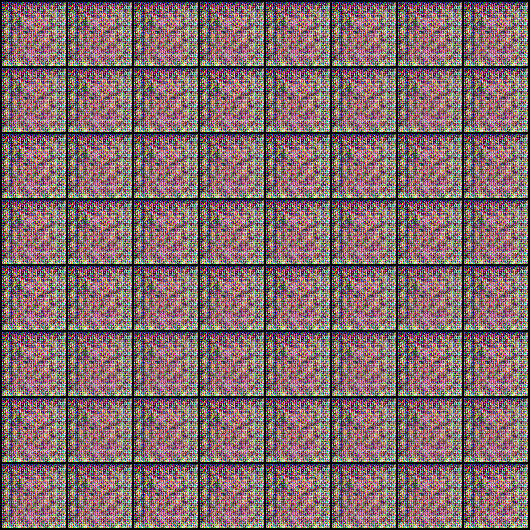

In [41]:
Image('./generated/generated-images-0001.png')


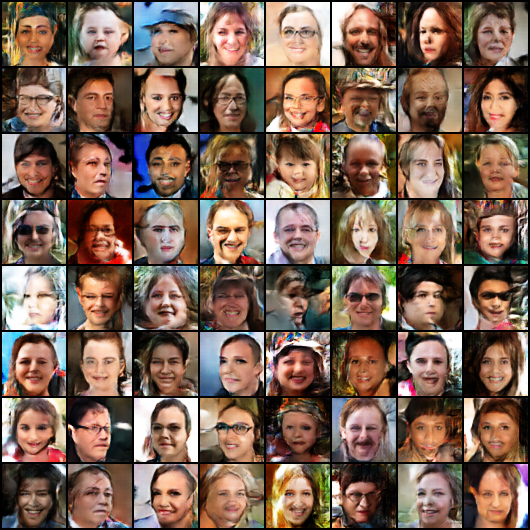

In [42]:
Image('./generated/generated-images-0024.png')


In [48]:
import cv2
import os

vid_fname = 'human_face_generator.mp4'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

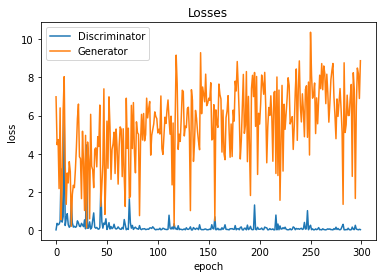

In [44]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

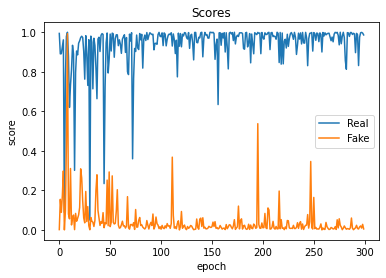

In [45]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

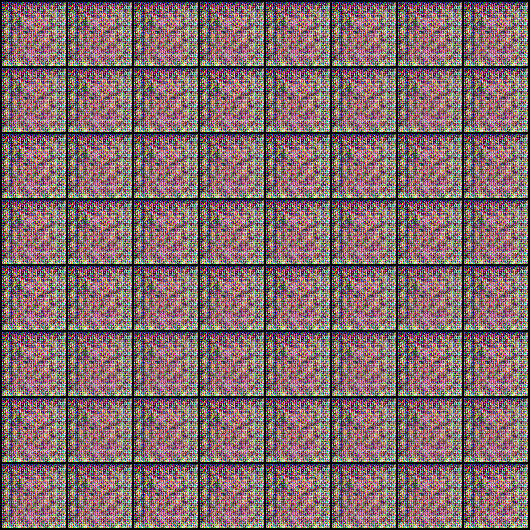

In [50]:
Image('./generated/generated-images-0001.png')

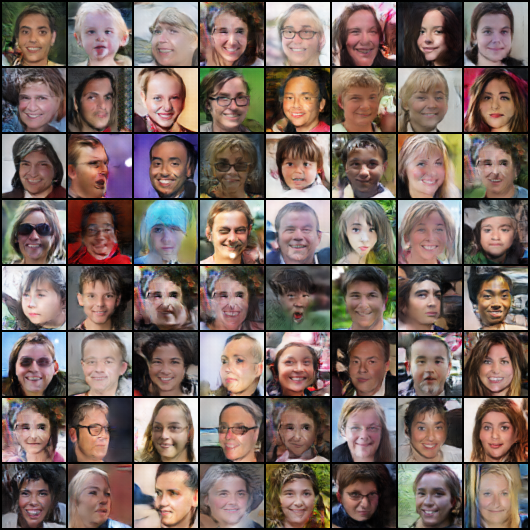

In [51]:
Image('./generated/generated-images-0299.png')

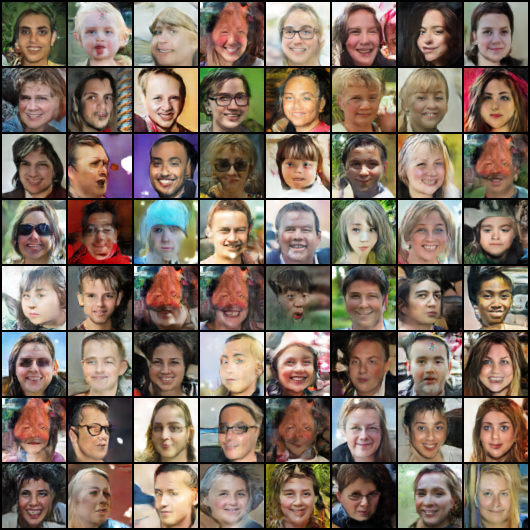

In [52]:
Image('./generated/generated-images-0300.png')